In [1]:
#When converting to Python file, change display function to print function

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import torch
from torch.utils.data import Dataset 
import random
import time
import datetime
import random
from transformers import GPT2LMHeadModel, GPT2Config
import numpy as np
from torch.utils.data import random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import json
import matplotlib.pyplot as plt


In [3]:
BATCH_SIZE = 16
DATASET_TO_USE = "UNION"

In [4]:
import pandas as pd

data = pd.read_csv('../Dataset/0OYkPK', sep=",", header=None)
data.columns = data.iloc[0]
data = data[1:]
data['full'] = data['sentence1']+ " " + data['sentence2']+ " " + data['sentence3']+ " " + data['sentence4']+ " " + data['sentence5']
data['input'] = data['sentence1']+ " " + data['sentence2']+ " " + data['sentence3']+ " " + data['sentence4']

val_data = pd.read_csv('../Dataset/XWjas1', sep=",", header=None)
val_data.columns = val_data.iloc[0]
val_data = val_data[1:]
#val_data['InputSentence5'] = val_data['RandomFifthSentenceQuiz1']
#val_data['InputSentence5'] = val_data['RandomFifthSentenceQuiz1']
val_data['InputSentence5']  = np.where(val_data['AnswerRightEnding']== '1', val_data['RandomFifthSentenceQuiz1'], val_data['RandomFifthSentenceQuiz2'])
val_data['full'] = val_data['InputSentence1']+ " " + val_data['InputSentence2']+ " " + val_data['InputSentence3']+ " " + val_data['InputSentence4']+ " " + val_data['InputSentence5']
val_data['input'] = val_data['InputSentence1']+ " " + val_data['InputSentence2']+ " " + val_data['InputSentence3']+ " " + val_data['InputSentence4']

print('The shapes of data and val_data')
print(data.shape)
print(val_data.shape)

The shapes of data and val_data
(52665, 9)
(1571, 11)


In [5]:
if(DATASET_TO_USE == 'UNION'):
    text_file = open('../UNION/train_data/train_human.txt', "r") #Read UNION File
    lines = text_file.readlines()
    lines = [item[:-1]for item in lines]
    text_file.close()

    data = pd.DataFrame(np.reshape(lines,(-1,6))) #Convert to pandas format
    data = data[[0,1,2,3,4]]
    data.columns = ['sentence1','sentence2','sentence3','sentence4','sentence5']
    data['full'] = data['sentence1']+ " " + data['sentence2']+ " " + data['sentence3']+ " " + data['sentence4']+ " " + data['sentence5']
    data['input'] = data['sentence1']+ " " + data['sentence2']+ " " + data['sentence3']+ " " + data['sentence4']
    #data

    text_file = open('../UNION/train_data/dev_human.txt', "r") #Read UNION File
    lines = text_file.readlines()
    lines = [item[:-1]for item in lines]
    text_file.close()

    val_data = pd.DataFrame(np.reshape(lines,(-1,6))) #Convert to pandas format
    val_data = val_data[[0,1,2,3,4]]
    val_data.columns = ['InputSentence1','InputSentence2','InputSentence3','InputSentence4','InputSentence5']
    val_data['full'] = val_data['InputSentence1']+ " " + val_data['InputSentence2']+ " " + val_data['InputSentence3']+ " " + val_data['InputSentence4']+ " " + val_data['InputSentence5']
    val_data['input'] = val_data['InputSentence1']+ " " + val_data['InputSentence2']+ " " + val_data['InputSentence3']+ " " + val_data['InputSentence4']
    val_data.full
    
    print('The shapes of data and val_data')
    print(data.shape)
    print(val_data.shape)
else:
    print('UNION was not loaded')

The shapes of data and val_data
(88344, 7)
(4908, 7)


In [6]:
with torch.cuda.device('cuda:1'):
    torch.cuda.empty_cache()

all_sentences = [x for x in data.full[:20000]]

val_sentences = [x for x in val_data.input]



In [7]:
all_sentences[0:10]
print('train_len ', len(all_sentences))
print('val_len ', len(val_sentences))

train_len  20000
val_len  4908


In [8]:
from transformers import GPT2Tokenizer
#get pretrained tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<sos>', pad_token='<pad>', padding_side = 'left')


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
max_len = int(np.max([len(tokenizer.encode(s)) for s in all_sentences]))
print(f"max_len {max_len}")

max_val = int(np.max([len(tokenizer.encode(s)) for s in val_sentences]))
print(f"max_val {max_val}")

max_len 117
max_val 101


In [10]:
def tokenize_seq(sent,tokenizer,max_length):
    return tokenizer('<sos>'+ sent , truncation=True, max_length=max_length, padding="max_length")

class JapanDataset(Dataset):

    def __init__(self, sentences, tokenizer, gpt2_type="gpt2", max_length=max_len):

        self.tokenizer = tokenizer 
        self.input_ids = []
        self.attn_masks = []

        for sentence in sentences:      
            encodings = tokenize_seq(sentence,tokenizer,max_length)

            self.input_ids.append(torch.tensor(encodings['input_ids']))
            self.attn_masks.append(torch.tensor(encodings['attention_mask']))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]   

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [11]:
import gc
gc.collect()

26

In [12]:
#create an instance of Dataset
train_set = JapanDataset(all_sentences, tokenizer, max_length=max_len)
val_set = JapanDataset(val_sentences, tokenizer, max_length=max_val)


#train_set, val_set = random_split(dataset, [train_size, val_size])
#print("train_size :",train_size)
#print("val_size   :",val_size)

gc.collect()

0

In [13]:
print(train_set[0])

(tensor([50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
        50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
        50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
        50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
        50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
        50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
        50258, 50258, 50258, 50258, 50258, 50258, 50257,    58,    44, 21358,
           60,   705,    82,  3397,   547, 22652,   764,   685,    44, 21358,
           60,   373, 22652,   355,   880,   764,   262,  7519,  1297,   465,
         3397,   340,   373, 27942,   764,   465,  3397,  7247,   290,  3066,
          284,   787,   257,  1487,   764,   484,  1392,  2405,   290,   685,
           44, 21358,    60,   319,   257,  5496,   764]), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  

In [14]:
#define dataloaders
train_dataloader = DataLoader(train_set,  sampler = RandomSampler(train_set), batch_size = BATCH_SIZE)
validation_dataloader = DataLoader(val_set, sampler = SequentialSampler(val_set), batch_size = BATCH_SIZE )

In [15]:
# Create default config
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# Load pretrained gpt2
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer))

# Create device
device = torch.device("cuda:1")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(),lr = 0.000005)
model = model.to(device)

In [16]:
from tqdm import tqdm
import re


#call model with a batch of input
def process_one_batch(batch):
    b_input_ids = batch[0].to(device)
    b_labels = batch[0].to(device)
    b_masks = batch[1].to(device)
    outputs  = model(b_input_ids,  attention_mask = b_masks,labels=b_labels)
    return outputs

#call model with a batch of input
def output_one_batch(batch):
    b_input_ids = batch[0].to(device)
    b_labels = batch[0].to(device)
    b_masks = batch[1].to(device)
    outputs  = model(b_input_ids,  num_beams=2 ,  attention_mask = b_masks,labels=b_labels)
    return outputs

#do one epoch for training
def train_epoch():
    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(tqdm(train_dataloader)):

        model.zero_grad()        
        outputs = process_one_batch( batch)
        loss = outputs[0]  
        batch_loss = loss.item()
        total_train_loss += batch_loss

        loss.backward()
        optimizer.step()


    avg_train_loss = total_train_loss / len(train_dataloader)  
    print("avg_train_loss",avg_train_loss)  
    elapsed_time = format_time(time.time() - t0)
    print("elapsed time for 1 training epoch : ",elapsed_time)
    return avg_train_loss

#do one epoch for eval
def eval_epoch():
    t0 = time.time()
    total_eval_loss = 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:            

        with torch.no_grad():        
            outputs = process_one_batch(batch)
            loss = outputs[0]              
            batch_loss = loss.item()
            total_eval_loss += batch_loss         

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    print("avg_val_loss",avg_val_loss) 
    elapsed_time = format_time(time.time() - t0)
    print("elapsed time for 1 eval epoch : ",elapsed_time)
    return avg_val_loss
    

#Runs the model on a set number of batches and saves the results to a json file
def save_results( num_batches = 15, iter = 0):
    indexes_list = []
    inputs_list = []
    predicted_list = []
    expected_list = []
    
    model.save_pretrained("saved_model_temp")

    #for i in tqdm(range(num_examples)):
    for i, batch in enumerate(tqdm(validation_dataloader)):
        if(num_batches != None and i>num_batches):
            break
        # Story is:
        #input_ids = tokenizer(val_data.input.iloc[i], return_tensors='pt')
        #input_ids.to(device)
        b_input_ids = batch[0].to(device)
        
        greedy_output = model.generate(
                b_input_ids,  #check stars   
                num_beams=2 ,
                return_dict_in_generate=True, 
                output_scores=True, 
                max_length=150,
                tempterature = 5,
                top_p = 4
                )
        
        print(greedy_output['sequences'].shape)
        output = tokenizer.batch_decode(greedy_output['sequences'])
        len_input = len(val_data.input.iloc[i])
        #output = tokenizer.decode(greedy_output[0], skip_special_tokens=True)
        b_outputs = []
        
        for b_idx in range(BATCH_SIZE):
            if(len(output) <= b_idx):
                break
            idx = BATCH_SIZE * i + b_idx
            end_words = val_data.InputSentence4
            in_words = val_data.input.iloc[idx]
            
            indexes_list.append(idx)
            inputs_list.append(val_data.input.iloc[idx])
            #predicted_list.append(output[b_idx])
            if(len(re.split('\? |! |\. ',output[b_idx]))<5):
                predicted_list.append('bad gen')
            else:
                predicted_list.append(re.split('\? |! |\. ',output[b_idx])[4] + '.')
            expected_list.append(val_data.InputSentence5.iloc[idx])
            
    outputs = pd.DataFrame()
    outputs['inputs'] = inputs_list
    outputs['predicted'] = predicted_list
    outputs['expected'] = expected_list
    
    print(outputs[:5])
    
    data = {}
    data['ex'] = []
    for i in range(len(indexes_list)):
        data['ex'].append({
            'idx': indexes_list[i],
            'input': inputs_list[i],
            'prediction': predicted_list[i],
            'expected': expected_list[i]

        })

    with open('test_cases/test_cases'+ str(iter)+'.json', 'w') as outfile:
        json.dump(data, outfile)

In [17]:

save_results(1)

  0%|          | 1/307 [00:01<07:39,  1.50s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


torch.Size([16, 150])


  1%|          | 2/307 [00:02<07:13,  1.42s/it]

torch.Size([16, 150])
                                              inputs  \
0  [MALE] is skiing . [MALE] falls off his skis ....   
1  [MALE] let his friend borrow his phone . the f...   
2  [FEMALE] asked her boyfriend to buy some coat ...   
3  [MALE] was driving to work . he got pulled ove...   
4  [MALE] 's mailman was n't very competent . whe...   

                                           predicted  \
0  <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos...   
1  <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos...   
2  <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos...   
3  <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos...   
4  <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos...   

                                            expected  
0                 [MALE] has broken his leg skiing .  
1                     the phone died shortly after .  
2        she had to go back and get the right kind .  
3   [MALE] agreed to fix it and only got a warning .  
4  the new mailman was happy 

100%|██████████| 1250/1250 [10:24<00:00,  2.00it/s]


avg_train_loss 3.2690387495040896
elapsed time for 1 training epoch :  0:10:25
avg_val_loss 2.0554845791297938
elapsed time for 1 eval epoch :  0:00:45


  0%|          | 1/307 [00:01<07:22,  1.45s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


torch.Size([16, 150])


  1%|          | 2/307 [00:02<07:12,  1.42s/it]

torch.Size([16, 150])
                                              inputs  \
0  [MALE] is skiing . [MALE] falls off his skis ....   
1  [MALE] let his friend borrow his phone . the f...   
2  [FEMALE] asked her boyfriend to buy some coat ...   
3  [MALE] was driving to work . he got pulled ove...   
4  [MALE] 's mailman was n't very competent . whe...   

                                           predicted  \
0  <pad> M <sos> <pad> <pad> <pad> <pad> <pad> <p...   
1  <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad...   
2  <sos> <pad> <sos> <pad> <pad> <pad> <pad> <pad...   
3  <sos> <pad> <pad> <pad> <pad> <pad> <pad> <pad...   
4  <sos> <pad> <pad> [MALE] was <sos> [ <sos> ] <...   

                                            expected  
0                 [MALE] has broken his leg skiing .  
1                     the phone died shortly after .  
2        she had to go back and get the right kind .  
3   [MALE] agreed to fix it and only got a warning .  
4  the new mailman was happy 

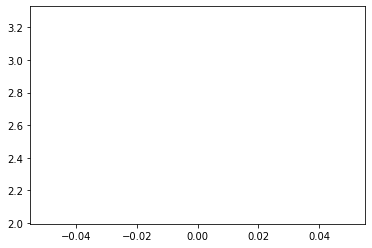

100%|██████████| 1250/1250 [10:24<00:00,  2.00it/s]


avg_train_loss 1.9996686980247498
elapsed time for 1 training epoch :  0:10:24
avg_val_loss 1.6065602772398957
elapsed time for 1 eval epoch :  0:00:44


  0%|          | 1/307 [00:01<07:22,  1.45s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


torch.Size([16, 150])


  1%|          | 2/307 [00:02<07:13,  1.42s/it]

torch.Size([16, 150])
                                              inputs  \
0  [MALE] is skiing . [MALE] falls off his skis ....   
1  [MALE] let his friend borrow his phone . the f...   
2  [FEMALE] asked her boyfriend to buy some coat ...   
3  [MALE] was driving to work . he got pulled ove...   
4  [MALE] 's mailman was n't very competent . whe...   

                                           predicted  \
0      [MALE] is a little bit of a lot of ice cream.   
1              [MALE] and he was going to the store.   
2   [FEMALE] was a little nervous about the weather.   
3  [MALE] and he was going to go to the police st...   
4        [MALE] was very happy with the new mailman.   

                                            expected  
0                 [MALE] has broken his leg skiing .  
1                     the phone died shortly after .  
2        she had to go back and get the right kind .  
3   [MALE] agreed to fix it and only got a warning .  
4  the new mailman was happy 

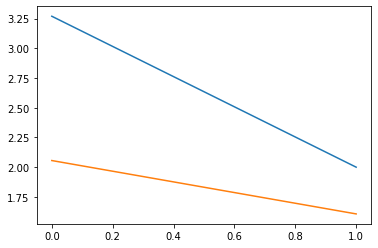

100%|██████████| 1250/1250 [10:24<00:00,  2.00it/s]


avg_train_loss 1.6681834889411926
elapsed time for 1 training epoch :  0:10:24
avg_val_loss 1.5003385753507334
elapsed time for 1 eval epoch :  0:00:44


  0%|          | 1/307 [00:01<07:21,  1.44s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


torch.Size([16, 150])


  1%|          | 2/307 [00:02<07:13,  1.42s/it]

torch.Size([16, 150])
                                              inputs  \
0  [MALE] is skiing . [MALE] falls off his skis ....   
1  [MALE] let his friend borrow his phone . the f...   
2  [FEMALE] asked her boyfriend to buy some coat ...   
3  [MALE] was driving to work . he got pulled ove...   
4  [MALE] 's mailman was n't very competent . whe...   

                             predicted  \
0     [MALE] is a little bit of water.   
1           [MALE] had a lot of money.   
2  [FEMALE] was very nervous about it.   
3             [MALE] was a little boy.   
4           [MALE] had a lot of money.   

                                            expected  
0                 [MALE] has broken his leg skiing .  
1                     the phone died shortly after .  
2        she had to go back and get the right kind .  
3   [MALE] agreed to fix it and only got a warning .  
4  the new mailman was happy to have [MALE] as a ...  


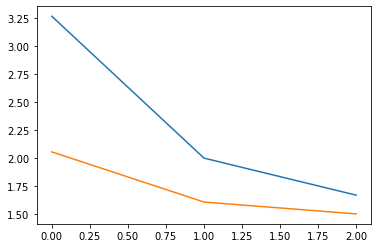

100%|██████████| 1250/1250 [10:23<00:00,  2.01it/s]


avg_train_loss 1.5287298753738403
elapsed time for 1 training epoch :  0:10:23
avg_val_loss 1.522203573186545
elapsed time for 1 eval epoch :  0:00:44


  0%|          | 1/307 [00:01<07:22,  1.45s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


torch.Size([16, 150])


  1%|          | 2/307 [00:02<07:12,  1.42s/it]

torch.Size([16, 150])
                                              inputs  \
0  [MALE] is skiing . [MALE] falls off his skis ....   
1  [MALE] let his friend borrow his phone . the f...   
2  [FEMALE] asked her boyfriend to buy some coat ...   
3  [MALE] was driving to work . he got pulled ove...   
4  [MALE] 's mailman was n't very competent . whe...   

                                           predicted  \
0  [MALE] was a little bit late for the first day...   
1  [MALE] was a friend of a friend of a friend of...   
2      [FEMALE] had a lot of money to buy a new car.   
3  [MALE] was a friend of a friend of a friend of...   
4          [MALE] was very happy to see the mailman.   

                                            expected  
0                 [MALE] has broken his leg skiing .  
1                     the phone died shortly after .  
2        she had to go back and get the right kind .  
3   [MALE] agreed to fix it and only got a warning .  
4  the new mailman was happy 

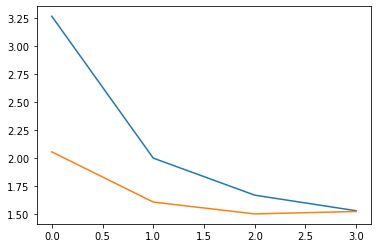

100%|██████████| 1250/1250 [10:26<00:00,  2.00it/s]


avg_train_loss 1.4493342525482178
elapsed time for 1 training epoch :  0:10:26


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [18]:
train_loss = []
val_loss = []
for i in range(15):
    train_loss.append(train_epoch())
    val_loss.append(eval_epoch())
    if(i<7):
        save_results(1, i)
    else:
        save_results(1, i)
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.show()
    plt.savefig('losses.png')
    model.save_pretrained("UNION_model")



save_results(None)

In [ ]:
save_results(1, 0)

##### 

In [ ]:
import os
#os.makedirs("saved_model")
#model.save_pretrained("saved_model")
#model = .from_pretrained("path/to/awesome-name-you-picked")

In [ ]:
# Create default config
#configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)
# Load pretrained gpt2
#model = GPT2LMHeadModel.from_pretrained("saved_model/", config=configuration)

model = GPT2LMHeadModel.from_pretrained("saved_model/")#, config=configuration)


model.resize_token_embeddings(len(tokenizer))

# Create device
device = torch.device("cuda:1")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(),lr = 0.0000005)
model = model.to(device)

In [ ]:

#do one epoch for eval
def save_results( num_batches = 15, iter = 0):
    indexes_list = []
    inputs_list = []
    predicted_list = []
    expected_list = []
        
    #for i in tqdm(range(num_examples)):
    for i, batch in enumerate(tqdm(validation_dataloader)):
        if(num_batches != None and i>num_batches):
            break
        # Story is:
        #input_ids = tokenizer(val_data.input.iloc[i], return_tensors='pt')
        #input_ids.to(device)
        b_input_ids = batch[0].to(device)
        
        greedy_output = model.generate(
                b_input_ids,  #check stars   
                num_beams=2 ,
                return_dict_in_generate=True, 
                output_scores=True, 
                max_length=150,
                #tempterature = 5,
                top_p = 10
                )
        
        print(greedy_output['sequences'].shape)
        output = tokenizer.batch_decode(greedy_output['sequences'])
        len_input = len(val_data.input.iloc[i])
        #output = tokenizer.decode(greedy_output[0], skip_special_tokens=True)
        b_outputs = []
        
        for b_idx in range(BATCH_SIZE):
            if(len(output) <= b_idx):
                break
            idx = BATCH_SIZE * i + b_idx
            end_words = val_data.InputSentence4
            in_words = val_data.input.iloc[idx]
            #if(len(output) <= b_idx):
            #    break
            #b_out = output[b_idx]
            #pred_sent = b_out[b_out.index('<sos>') + len(in_words) + 13:]
            #if(pred_sent.find('.') != -1):
            #    pred_sent = pred_sent[:pred_sent.index('.')+1]
            #else:
            #    pred_sent = pred_sent
            
            indexes_list.append(idx)
            inputs_list.append(val_data.input.iloc[idx])
            #predicted_list.append(output[b_idx])
            if(len(re.split('\? |! |\. ',output[b_idx]))<5):
                predicted_list.append('bad gen')
            else:
                predicted_list.append(re.split('\? |! |\. ',output[b_idx])[4] + '.')
            expected_list.append(val_data.InputSentence5.iloc[idx])
            
    outputs = pd.DataFrame()
    outputs['inputs'] = inputs_list
    outputs['predicted'] = predicted_list
    outputs['expected'] = expected_list
    
    print(outputs[:5])

            
    
    
    data = {}
    data['ex'] = []
    for i in range(len(indexes_list)):
        data['ex'].append({
            'idx': indexes_list[i],
            'input': inputs_list[i],
            'prediction': predicted_list[i],
            'expected': expected_list[i]

        })

    with open('test_cases/test_cases'+ str(iter)+'.json', 'w') as outfile:
        json.dump(data, outfile)
        
save_results(1, 0)